My goal is to create a chess engine based on convolutional neural nets and reinforcement learning.  But first I will try to answer the question "can convnets learn useful features to represent chess positions".  In this notebook, I will train autoencoders on chess positions and attempt to find neurons that have learned semantically meaningful features.

In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [86]:
import chess
import chess.pgn
import math
import pystockfish
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import *

# Load data

In [ ]:
board_fens = load_boards_from_pgnf('data/ficsgamesdb_201701_chess_nomovetimes_1500955.pgn', num_games=200)

In [ ]:
X = fens_to_arrs(board_fens)
eval_inds = np.random.choice(X.shape[0], 1000)

X_train = X[~eval_inds]
X_eval = X[eval_inds]

In [ ]:
scored = score_fens(board_fens)

In [ ]:
with open('data.json', 'w') as fp:
    json.dump(scored, fp)

In [53]:
with open('data/data.json') as fp:
    data = json.load(fp)

X, y = convert_and_normalize(data)

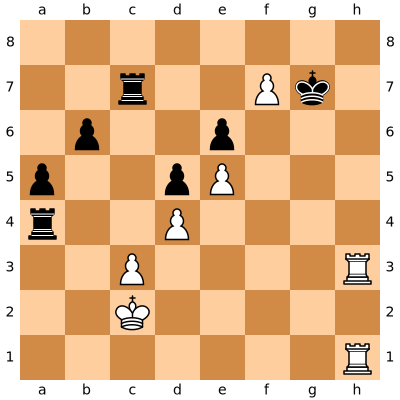

In [71]:
chess.Board(fen=data[90][0])

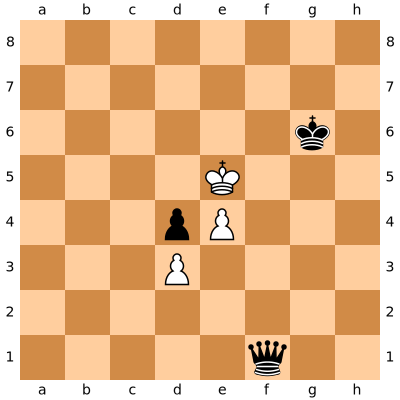

In [78]:
arr_to_board(X[128])

# Regression

In [152]:
X_ph = tf.placeholder('float', [None, 8, 8, 6])
y_ph = tf.placeholder('float', [None, 1])
cnn = create_cnn(X_ph, y_ph, [50, 50, 'pool', 20, 'pool'], 1024)

In [155]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
train_labeled(cnn, X[:10], y[:10], X_ph, y_ph, sess, batch_size=10, lr=1e-7)

0  cost 8.63114e+07
1000  cost 3.33943e+07
2000  cost 6.6456e+06
3000  cost 854958.0
4000  cost 290887.0
5000  cost 367438.0
6000  cost 284224.0
7000  cost 386458.0
8000  cost 346814.0
9000  cost 136407.0
10000  cost 156077.0
11000  cost 92356.3
12000  cost 187300.0
13000  cost 70848.9
14000  cost 94431.6
15000  cost 131678.0
16000  cost 49252.7
17000  cost 81136.9
18000  cost 80025.5
19000  cost 104997.0


In [151]:
np.sum(np.square(y[:10] - 5))

12757

## First experiment: fully connected autoencoder

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [ ]:
flat_input_ph = tf.placeholder("float", [None, 8 * 8 * 6])
fc_autoencoder1 = create_fully_connected(flat_input_ph, [60, 30, 20], sess)

In [ ]:
# writer = tf.summary.FileWriter('./logs/', graph=tf.get_default_graph())

In [ ]:
train(fc_autoencoder1, X_train, True, flat_input_ph, sess, num_iters=2000)

In [ ]:
decodedLong = sess.run(fc_autoencoder1['decoded'], feed_dict={flat_input_ph: np.reshape(X_eval, (X_eval.shape[0], -1))})

decoded = np.reshape(decodedLong, (X_eval.shape[0], 8, 8, 6))

In [ ]:
np.sum(quantize_arr_vec(decoded) != X_eval) / decoded.size

In [ ]:
arr_to_board(decoded[40])
arr_to_board(X_eval[40])

## Overfit on a tiny training set

In [ ]:
small_inds = np.random.choice(X.shape[0], 10)
X_small = X[small_inds]

In [ ]:
flat_input_ph = tf.placeholder("float", [None, 8 * 8 * 6])
# conv_ae = create_cae(input_ph, [], 400)
fc_autoencoder1 = create_fully_connected(flat_input_ph, [60, 30, 20], sess)

In [ ]:
train(fc_autoencoder1, X_small, True, flat_input_ph, sess, num_iters=10000, lr=.001, batch_size=10)

In [ ]:
arr_to_board(X_small[0])
arr_to_board(np.reshape(sess.run(fc_autoencoder1['decoded'],
                                 feed_dict={flat_input_ph: np.reshape(X_small, (1, -1))})[0], (8, 8, 6)))

## Now a simple conv net

In [ ]:
input_ph = tf.placeholder("float", [None, 8, 8, 6])
conv_ae = create_cae(input_ph, [50, 50, 'pool', 50], 40)

In [ ]:
train(conv_ae, X_train, False, input_ph, sess, num_iters=10000, lr=.001)

In [ ]:
decoded = sess.run(conv_ae['decoded'], feed_dict={input_ph: X_eval})

In [ ]:
np.sum(quantize_arr_vec(decoded) != X_eval) / decoded.size

In [ ]:
arr_to_board(X_eval[52])
arr_to_board(decoded[52])

In [ ]:
train_decoded = sess.run(conv_ae['decoded'], feed_dict={input_ph: X_train})

In [ ]:
np.sum(train_decoded > .5)

In [ ]:
np.sum(X_train > .5)

In [ ]:
np.sum(decoded > .5)

# Come back to this later

In [ ]:
neuron = autoencoder['encoded'][0][5]
neuron_grad = tf.gradients(neuron, x)

# board = np.zeros((8,8,6))
board = np.random.normal(size=(8,8,6), scale=.1)
print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

for i in range(10000):
    grad = sess.run(neuron_grad, feed_dict={x: np.reshape(board, (1, -1))})[0]
    grad = np.reshape(grad, (8,8,6))
    board += 1e-3 * grad
    board[board > 1] = 1
    board[board < -1] = -1
    
    if i % 1000 == 0:
        print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

In [ ]:
arr_to_board(board)

In [ ]:
board